Defining image Plotting function

In [1]:
import matplotlib.pyplot as plt

def plot_images(img1,img2,title):
    plt.figure(figsize=(10,5))
    plt.suptitle(title,fontsize=16)

    plt.subplot(1,2,1)
    plt.imshow(img1,cmap='bone')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img2,cmap='bone')
    plt.axis('off')

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [ ]:
# Choose axis: 0 = sagittal, 1 = coronal, 2 = axial
def get_middle_slice(image_3d, axis=2):
    middle_index = image_3d.shape[axis] // 2
    if axis == 0:
        return image_3d[middle_index, :, :]
    elif axis == 1:
        return image_3d[:, middle_index, :]
    else:
        return image_3d[:, :, middle_index]


Loading Skull Striped Image

In [3]:
import nibabel as nb   #Importing dependancies

path_1=r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\datasets\ADNI_0~1.NII\ADNI_0~1.NII"        
path_2=r"C:\Users\reeba\OneDrive\Desktop\Work\Coding\Python\datasets\ADNI_0~2.NII\ADNI_0~1.NII"

image_1=nb.load(path_1)              #Loading nii files
image_2=nb.load(path_2)

image_1_data=image_1.get_fdata()    #Getting functional data
image_2_data=image_2.get_fdata()


mid_1=image_1_data.shape[2]//2      #Analyising shape
mid_2=image_2_data.shape[2]//2

print(mid_1, mid_2)

83 83


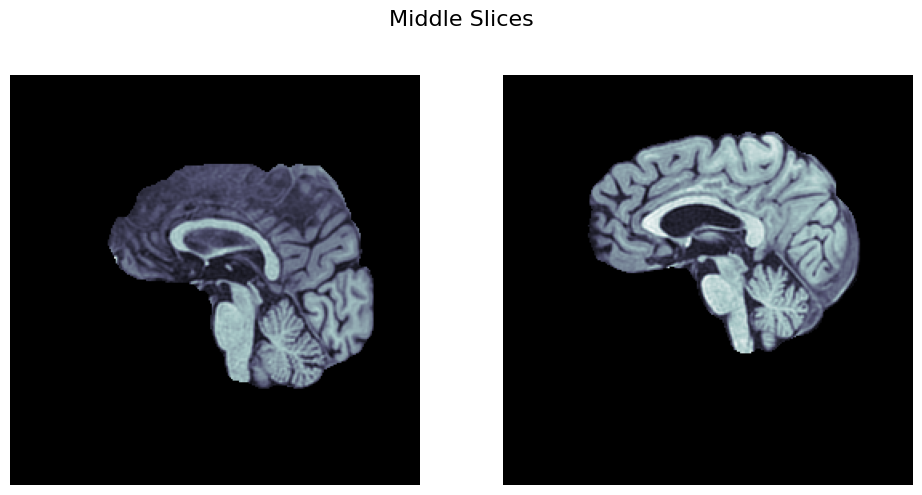

In [4]:
mid=mid_1

img_1=image_1_data[:,:,mid]        #Getting middle slice for best clarity
img_2=image_2_data[:,:,mid]

plot_images(img_1,img_2,"Middle Slices")


Cropping And Padding Canonical Images


In [84]:
import torchio as tio
import numpy as np

#Defining Subject
subject = tio.Subject(
    mri_1=tio.ScalarImage(path_1),
    mri_2=tio.ScalarImage(path_2)
)

#Applying Transformation 
subject = tio.ToCanonical()(subject)

#Resampling to appropriate space
subject = tio.Resample(target=subject['mri_1'])(subject)

#Applying CropOrPad
crop_or_pad = tio.CropOrPad((200, 260, 200))
cropped_subject = crop_or_pad(subject)

img1 = cropped_subject['mri_1'].data.squeeze().numpy()
img2 = cropped_subject['mri_2'].data.squeeze().numpy()

#Getting Saggital Plane
view_axis = 0  # sagittal
cropped_im_1 = np.flip(get_middle_slice(img1, axis=view_axis), axis=1)
cropped_im_2 = np.flip(get_middle_slice(img2, axis=view_axis), axis=1)


print(cropped_im_1.shape,cropped_im_2.shape )




(260, 200) (260, 200)


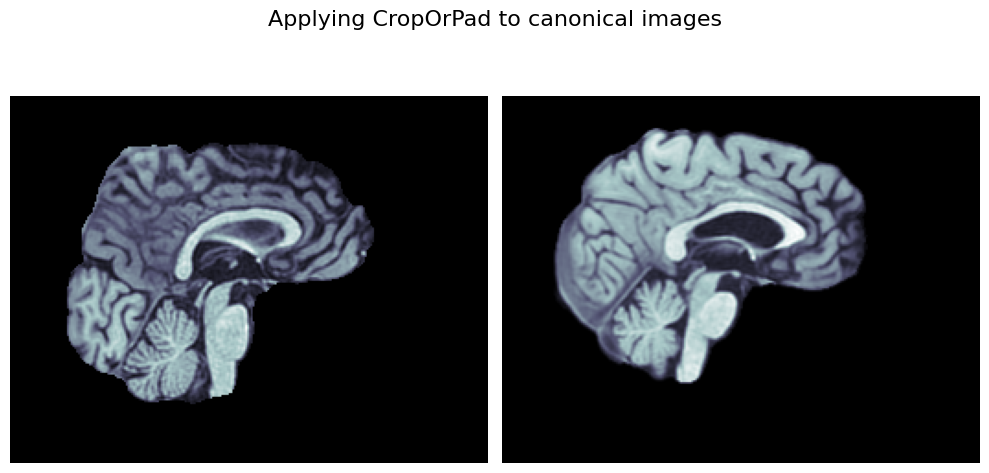

In [86]:


plot_images(cropped_im_1.T,cropped_im_2.T,"Applying CropOrPad to canonical images")

Applying Z-Normalization

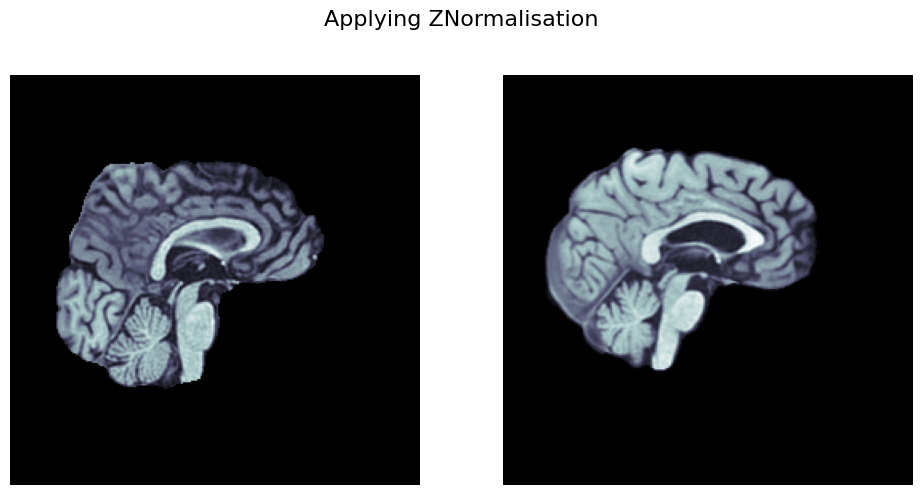

In [97]:
subject = tio.ZNormalization()(subject)

#Flipping to get correct view
view_axis = 0  # sagittal
znorm_im_1 = np.flip(get_middle_slice(img1, axis=view_axis), axis=1)
znorm_im_2 = np.flip(get_middle_slice(img2, axis=view_axis), axis=1)

plot_images(znorm_im_1.T,znorm_im_2.T, "Applying ZNormalisation")

Applying CLAHE

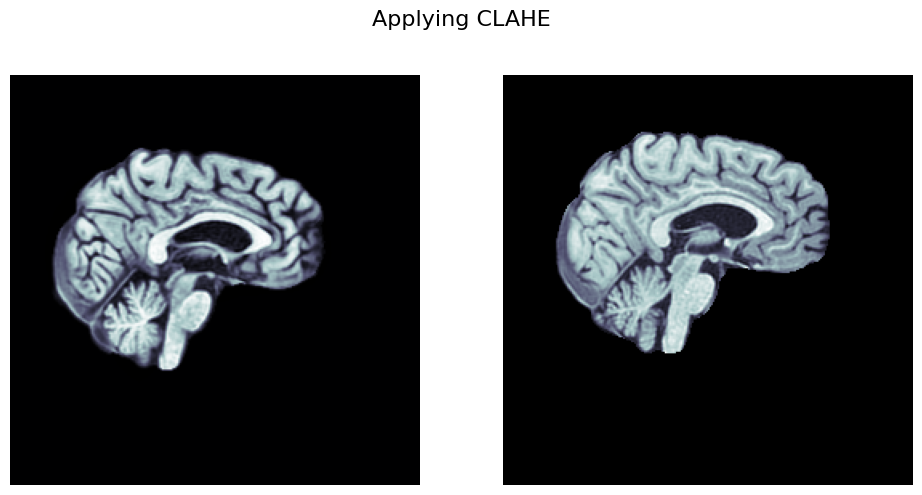

In [90]:
import cv2

def apply_clahe(image):
    img_norm= cv2.normalize(image, None,0,255, cv2.NORM_MINMAX)
    img_unit8 = img_norm.astype(np.uint8)

    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_unit8)

    return clahe_img

clahe_image_1= get_middle_slice(img1, axis=0)
clahe_image_2=get_middle_slice(img2, axis=0)

clahe_img_1=apply_clahe(clahe_image_1)
clahe_img_2=apply_clahe(clahe_image_2)

clahe_im_1 = np.flip(clahe_img_1,axis=1)
clahe_im_1 = np.flip(clahe_img_2,axis=1)


plot_images(clahe_im_1.T,clahe_im_2.T,"Applying CLAHE")

Applying Adaptive Thresholding

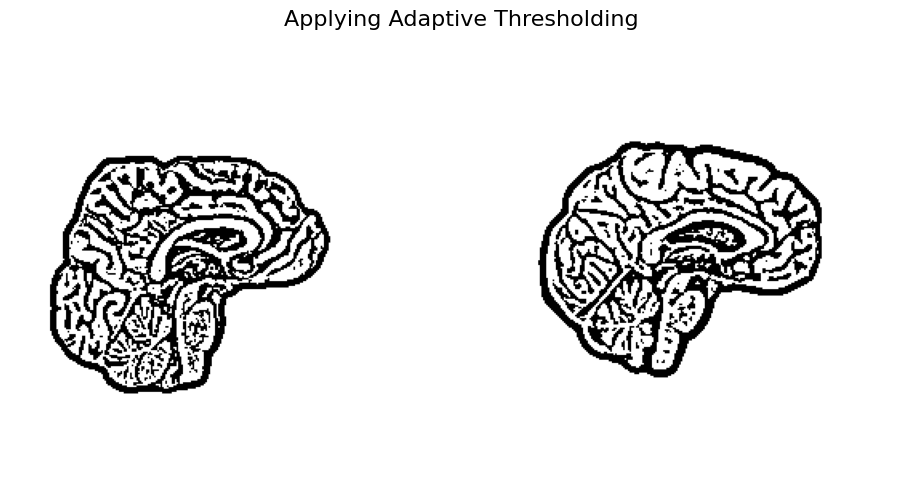

In [91]:
def apply_adaptive_thresholding(image):
    img_norm= cv2.normalize(image, None,0,255, cv2.NORM_MINMAX)
    img_uint8 = img_norm.astype(np.uint8)

    adaptive_thresh=cv2.adaptiveThreshold(
        img_uint8,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize=11,C=2
    )

    return adaptive_thresh


thresh_image_1= get_middle_slice(img1, axis=0)
thresh_image_2=get_middle_slice(img2, axis=0)

thresh_img_1=apply_adaptive_thresholding(thresh_image_1)
thresh_img_2=apply_adaptive_thresholding(thresh_image_2)

thresh_im_1 = np.flip(thresh_img_1,axis=1)
thresh_im_2 = np.flip(thresh_img_2, axis=1)

plot_images(thresh_im_1.T,thresh_im_2.T, "Applying Adaptive Thresholding")


Applying Gaussian Blur


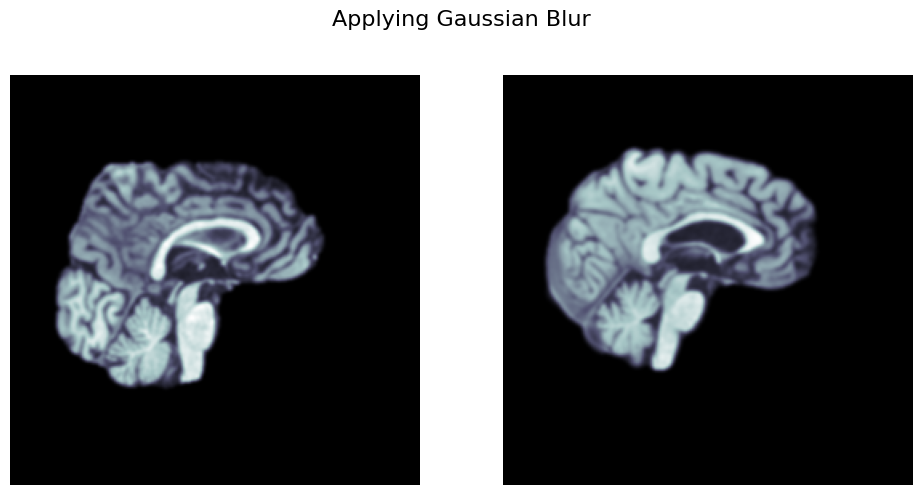

In [92]:
def apply_gaussian_blur(image, kernel_size=(5,5), sigma=0):
    img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_norm.astype(np.uint8)
    blurred_img = cv2.GaussianBlur(img_uint8, kernel_size, sigma)
    return blurred_img

blur_slice_1 = get_middle_slice(img1, axis=0)
blur_slice_2 = get_middle_slice(img2, axis=0)

blur_img_1 = apply_gaussian_blur(blur_slice_1)
blur_img_2 = apply_gaussian_blur(blur_slice_2)

blur_im_1 = np.flip(blur_img_1, axis=1).T
blur_im_2 = np.flip(blur_img_2, axis=1).T

plot_images(blur_im_1, blur_im_2, "Applying Gaussian Blur")


Applying Morphological operations

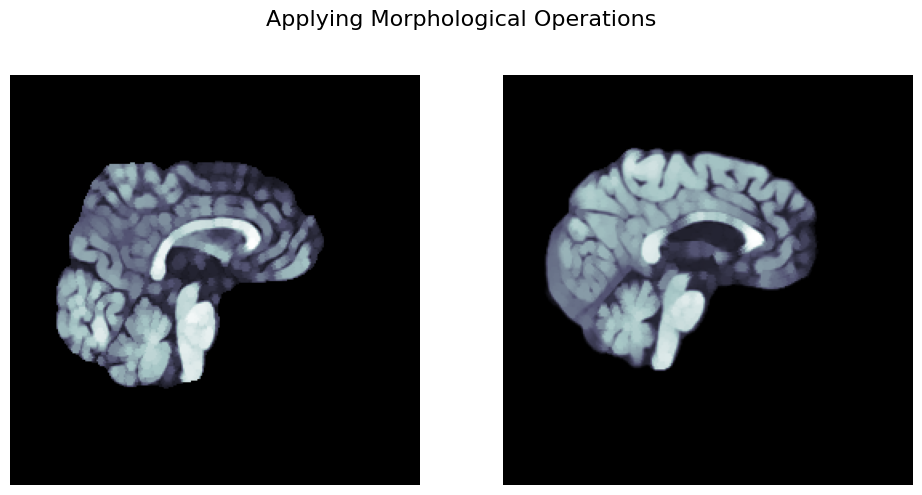

In [95]:
def apply_morph_open(image, kernel_size=(5,5)):
    img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_norm.astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    morph_img = cv2.morphologyEx(img_uint8, cv2.MORPH_OPEN, kernel)
    return morph_img

morph_slice_1 = get_middle_slice(img1, axis=0)
morph_slice_2 = get_middle_slice(img2, axis=0)

morph_img_1 = apply_morph_open(morph_slice_1)
morph_img_2 = apply_morph_open(morph_slice_2)

morph_im_1 = np.flip(morph_img_1, axis=1).T
morph_im_2 = np.flip(morph_img_2, axis=1).T

plot_images(morph_im_1, morph_im_2, "Applying Morphological Operations")
